In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM,
                                   Dense, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D,
                                   Concatenate, Layer, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

project_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/'

tf.random.set_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported successfully!


In [ ]:
def load_preprocessed_data():
    train_df = pd.read_csv(project_path + 'train_data.csv', low_memory=False)
    test_df = pd.read_csv(project_path + 'test_data.csv')

    print(f"Training data: {train_df.shape}")
    print(f"Test data: {test_df.shape}")

    if 'cleaned_review' in train_df.columns:
        print("Using pre-cleaned text columns")
        review_col = 'cleaned_review'
        summary_col = 'cleaned_summary'
    else:
        print("Using original text columns")
        review_col = 'reviewText'
        summary_col = 'summary'

    train_df['combined_text'] = train_df[review_col].fillna('') + " " + train_df[summary_col].fillna('')
    test_df['combined_text'] = test_df[review_col].fillna('') + " " + test_df[summary_col].fillna('')

    y_train = train_df['overall'] - 1

    print("\nRating distribution in training data:")
    print(train_df['overall'].value_counts().sort_index())

    return train_df, test_df, y_train

train_df, test_df, y_train = load_preprocessed_data()

def sample_data_balanced(df, y, samples_per_label=2500):
    sampled_indices = []

    for label in range(5):
        label_indices = df.index[y == label].tolist()

        if len(label_indices) > samples_per_label:
            selected_indices = np.random.choice(label_indices, size=samples_per_label, replace=False)
            sampled_indices.extend(selected_indices)
        else:
            sampled_indices.extend(label_indices)

    df_sampled = df.loc[sampled_indices].copy()
    y_sampled = y[sampled_indices]

    print(f"Sampled data distribution:")
    for label in range(5):
        count = np.sum(y_sampled == label)
        print(f"Label {label+1}: {count} samples")

    return df_sampled, y_sampled

train_df_sampled, y_train_sampled = sample_data_balanced(train_df, y_train, samples_per_label=2500)
print(f"Original training size: {len(train_df)}")
print(f"Sampled training size: {len(train_df_sampled)}")

Training data: (838944, 11)
Test data: (20000, 10)
Using original text columns

Rating distribution in training data:
overall
1     82950
2     56756
3     81239
4    156514
5    461485
Name: count, dtype: int64
Sampled data distribution:
Label 1: 2500 samples
Label 2: 2500 samples
Label 3: 2500 samples
Label 4: 2500 samples
Label 5: 2500 samples
Original training size: 838944
Sampled training size: 12500


In [ ]:
def improved_text_vectorization(train_texts, test_texts, max_features=20000, max_len=180):
    print("Vectorizing text data...")

    tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>",
                         filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                         lower=True)
    tokenizer.fit_on_texts(train_texts)

    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
    X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

    print(f"Training sequences: {X_train.shape}")
    print(f"Test sequences: {X_test.shape}")
    print(f"Vocabulary size: {len(tokenizer.word_index)}")

    return X_train, X_test, tokenizer

X_train, X_test, tokenizer = improved_text_vectorization(
    train_df_sampled['combined_text'].values,
    test_df['combined_text'].values,
    max_features=20000,
    max_len=180
)

Vectorizing text data...
Training sequences: (12500, 180)
Test sequences: (20000, 180)
Vocabulary size: 28822


In [ ]:
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            name="attention_weights",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        super(SimpleAttention, self).build(input_shape)

    def call(self, inputs):
        attention_scores = tf.tensordot(inputs, self.attention_weights, axes=1)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        weighted_output = inputs * attention_weights
        return tf.reduce_sum(weighted_output, axis=1)

def build_final_model(vocab_size, max_len=180, num_classes=5):
    print("Building final optimized model...")

    text_input = Input(shape=(max_len,), name="text_input")

    # Embedding بدون ماسک
    embedding = Embedding(
        input_dim=vocab_size + 1,
        output_dim=128,
        input_length=max_len,
        mask_zero=False,  # مهم: غیرفعال کردن ماسک
        name="embedding"
    )(text_input)

    # دو لایه LSTM دوطرفه
    lstm1 = Bidirectional(
        LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(embedding)

    lstm2 = Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(lstm1)

    # توجه ساده
    attention = SimpleAttention()(lstm2)

    # Pooling‌های مختلف
    global_max = GlobalMaxPooling1D()(lstm2)
    global_avg = GlobalAveragePooling1D()(lstm2)

    # ترکیب همه ویژگی‌ها
    concatenated = Concatenate()([attention, global_max, global_avg])

    # نرمال‌سازی
    bn = BatchNormalization()(concatenated)

    # طبقه‌بندی
    x = Dense(64, activation='relu')(bn)
    x = Dropout(0.5)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.4)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=text_input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ساخت مدل
model = build_final_model(
    vocab_size=min(20000, len(tokenizer.word_index)),
    max_len=180
)

print(model.summary())

Building final optimized model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 180, 128)  │  2,560,128 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 180, 256)  │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 180, 128)  │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_attention    │ (None, 128)       │        128 │ bidirectional_1[… │
│ (SimpleAttention)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ simple_attention… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 384)       │      1,536 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     24,640 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        165 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,016,197 (11.51 MB)

 Trainable params: 3,015,429 (11.50 MB)

 Non-trainable params: 768 (3.00 KB)

None


In [ ]:
def prepare_training_data(X_train, y_train, validation_size=0.15):
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train,
        test_size=validation_size,
        random_state=42,
        stratify=y_train
    )

    print(f"Training split: {X_train_split.shape}")
    print(f"Validation split: {X_val.shape}")

    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_split),
        y=y_train_split
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Class weights:", {f"Class {k+1}": f"{v:.2f}" for k, v in class_weight_dict.items()})

    return X_train_split, X_val, y_train_split, y_val, class_weight_dict

X_train_split, X_val, y_train_split, y_val, class_weight_dict = prepare_training_data(
    X_train, y_train_sampled
)

Training split: (10625, 180)
Validation split: (1875, 180)
Class weights: {'Class 1': '1.00', 'Class 2': '1.00', 'Class 3': '1.00', 'Class 4': '1.00', 'Class 5': '1.00'}


In [ ]:
print("Starting training...")

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=15,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.2071 - loss: 1.6859 - val_accuracy: 0.3163 - val_loss: 1.4556 - learning_rate: 0.0010
Epoch 2/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.3413 - loss: 1.4334 - val_accuracy: 0.3824 - val_loss: 1.2879 - learning_rate: 0.0010
Epoch 3/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.4275 - loss: 1.2707 - val_accuracy: 0.4597 - val_loss: 1.2772 - learning_rate: 0.0010
Epoch 4/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.4887 - loss: 1.1432 - val_accuracy: 0.4827 - val_loss: 1.2314 - learning_rate: 0.0010
Epoch 5/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.5444 - loss: 1.0306 - val_accuracy: 0.4811 - val_loss: 1.3165 - learning_rate: 0.0010
Epoch 6/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.5987 - loss: 0.9151 - val_accuracy: 0.4805 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 7/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy


COMPREHENSIVE EVALUATION
Validation Accuracy: 0.4827
Validation F1-Score (Micro): 0.4827
Validation F1-Score (Macro): 0.4677
Validation F1-Score (Weighted): 0.4677

Detailed Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.76      0.65       375
           2       0.36      0.31      0.34       375
           3       0.39      0.25      0.30       375
           4       0.39      0.42      0.41       375
           5       0.62      0.66      0.64       375

    accuracy                           0.48      1875
   macro avg       0.47      0.48      0.47      1875
weighted avg       0.47      0.48      0.47      1875

Confusion Matrix:
[[286  61   7   9  12]
 [148 118  56  34  19]
 [ 46  93  93 125  18]
 [ 14  36  64 159 102]
 [ 16  18  16  76 249]]


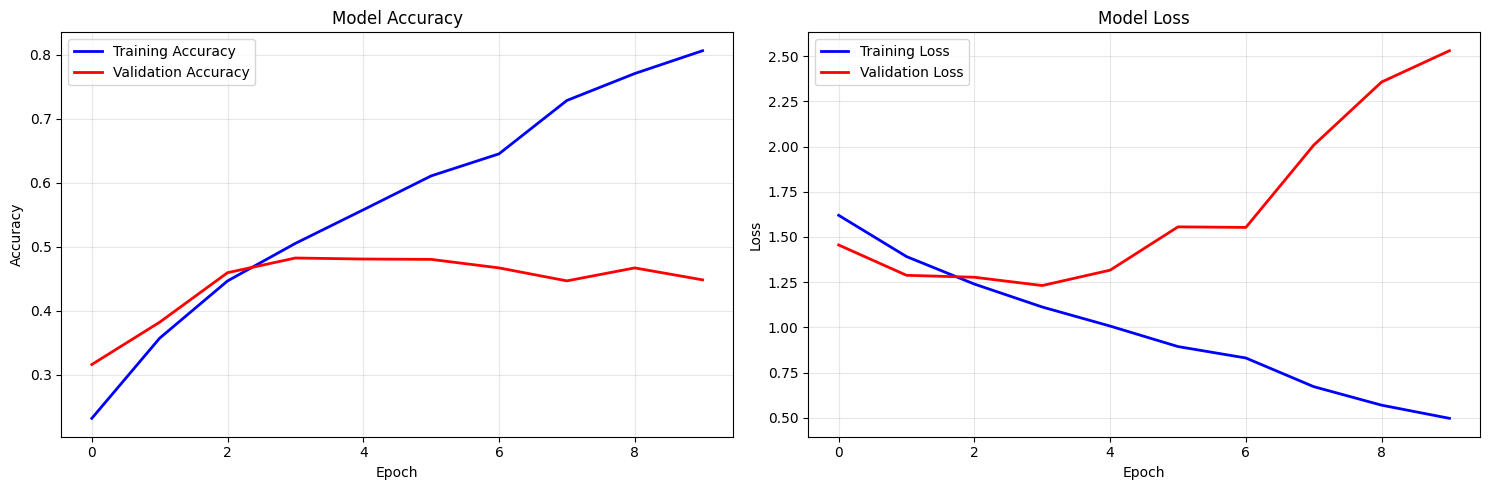

In [ ]:
def comprehensive_evaluate(model, X_val, y_val, history):
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION")
    print("="*60)

    y_pred_proba = model.predict(X_val, batch_size=128, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = np.mean(y_pred == y_val)
    f1_micro = f1_score(y_val, y_pred, average='micro')
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_weighted = f1_score(y_val, y_pred, average='weighted')

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1-Score (Micro): {f1_micro:.4f}")
    print(f"Validation F1-Score (Macro): {f1_macro:.4f}")
    print(f"Validation F1-Score (Weighted): {f1_weighted:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_val, y_pred, target_names=['1', '2', '3', '4', '5']))

    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # نمودارهای یادگیری
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return y_pred

y_val_pred = comprehensive_evaluate(model, X_val, y_val, history)

In [ ]:
def generate_predictions(model, X_test):
    print("Generating predictions...")
    test_pred_proba = model.predict(X_test, batch_size=128, verbose=1)
    test_pred = np.argmax(test_pred_proba, axis=1) + 1
    return test_pred

test_predictions = generate_predictions(model, X_test)

print("\nPrediction distribution:")
unique, counts = np.unique(test_predictions, return_counts=True)
for rating, count in zip(unique, counts):
    percentage = (count / len(test_predictions)) * 100
    print(f"Rating {rating}: {count:6d} samples ({percentage:5.1f}%)")

submission_df = pd.DataFrame({'predicted': test_predictions})
submission_df.to_csv(project_path + 'q2_submission.csv', index=False)

print(f"\nSubmission file saved: q2_submission.csv")
print("First 10 predictions:")
print(submission_df.head(10))

Generating predictions...
157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 797ms/step

Prediction distribution:
Rating 1:   3339 samples ( 16.7%)
Rating 2:   3470 samples ( 17.3%)
Rating 3:   3483 samples ( 17.4%)
Rating 4:   5384 samples ( 26.9%)
Rating 5:   4324 samples ( 21.6%)

Submission file saved: q2_submission.csv
First 10 predictions:
   predicted
0          2
1          1
2          1
3          1
4          1
5          1
6          1
7          5
8          2
9          2
